In [ ]:
# default_exp dataset

# Dataset

> API details.

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
import copy

import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import pytorch_lightning as pl
from tqdm import tqdm

import cv2
from PIL import Image
import albumentations as A

from isic.config import *
from isic.sampler import ImbalancedDatasetSampler
from isic.utils.dataset import SkinLabels, from_label_idx_to_key, preprocess_df, get_default_train_transform, get_default_val_transform, get_advanced_train_transform

In [ ]:
#export
class SkinDataset(Dataset):
    def __init__(self, df, transform=None, labels=None):
        self.df = df
        self.transform = transform
        self.labels = labels

    def __getitem__(self, i):
        if i >= len(self): raise IndexError
        image = cv2.imread(self.df['path'][i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        y = torch.tensor(int(self.df['label_index'][i]))

        # Albumentation only
        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)
        image = torch.tensor(image).float()

        return {"img": image, "label": y}

    def __len__(self):
        return len(self.df)

    def show_image(self, index=None):
        dataset = self
        n_samples = len(dataset)

        if not index:
            index = int(np.random.random()*n_samples)
        else:
            if index >= n_samples or index < 0:
                print('Invalid index.')
                return

        d = dataset[index]

        plt.imshow(d['img'].permute(1,2,0))
        plt.axis('off')
        plt.title(self.labels[d['label']] if self.labels else d['label'])

    def show_grid(self, n_rows=5, n_cols=5):
        dataset = self
        array = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), n_rows*n_cols, replace=False))

        plt.figure(figsize=(12, 12))
        for row in range(n_rows):
            for col in range(n_cols):
                index = n_cols * row + col
                plt.subplot(n_rows, n_cols, index + 1)
                plt.imshow(array[index]['img'].permute(1, 2, 0))
                plt.axis('off')
                label = self.labels[int(array[index]['label'])] if self.labels else int(array[index]['label'])
                plt.title(label, fontsize=12)
        plt.tight_layout()

In [ ]:
#export
class SkinDataModule(pl.LightningDataModule):
    def __init__(self, image_size=224, valid_size=0.2, bs=64, df_path=PathConfig.CSV_PATH, imbalanced_sampler=True, transform=None, cutout=True):
        self.df_path = df_path
        self.valid_size = valid_size
        self.bs = bs
        self.imbalanced_sampler = imbalanced_sampler
        
        self.train_transform = transform
        if self.train_transform is None:
            self.train_transform = get_default_train_transform(image_size, cutout)
            
        self.val_transform = get_default_val_transform(image_size)
        
        self.dims = (3, image_size, image_size)

    def setup(self, stage):
        def _get_label(dataset, idx):
            return int(dataset.df['label_index'][idx])
        
        if stage == 'fit' or stage is None:
            df = pd.read_csv(self.df_path)
            train_df, valid_df, self.labels = preprocess_df(df, self.valid_size)
            self.train_ds = SkinDataset(train_df, self.train_transform, self.labels)
            self.val_ds = SkinDataset(valid_df, self.val_transform, self.labels)

            if self.imbalanced_sampler:
                self.sampler = ImbalancedDatasetSampler(self.train_ds, callback_get_label=_get_label)
            else:
                self.sampler = RandomSampler(self.train_ds)

            self.dims = tuple(self.train_ds[0]["img"].shape)

        if stage == 'test':
            #TODO
            pass
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.bs, 
                          sampler=self.sampler,
                          num_workers=4, pin_memory=True
                         )

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.bs, num_workers=4, pin_memory=True)

    def test_dataloader(self):
        #TODO
        return DataLoader(self.val_ds, batch_size=self.bs, num_workers=4, pin_memory=True)

In [ ]:
dm = SkinDataModule(transform=get_default_train_transform(no_norm=True))
dm.prepare_data()
dm.setup('fit')

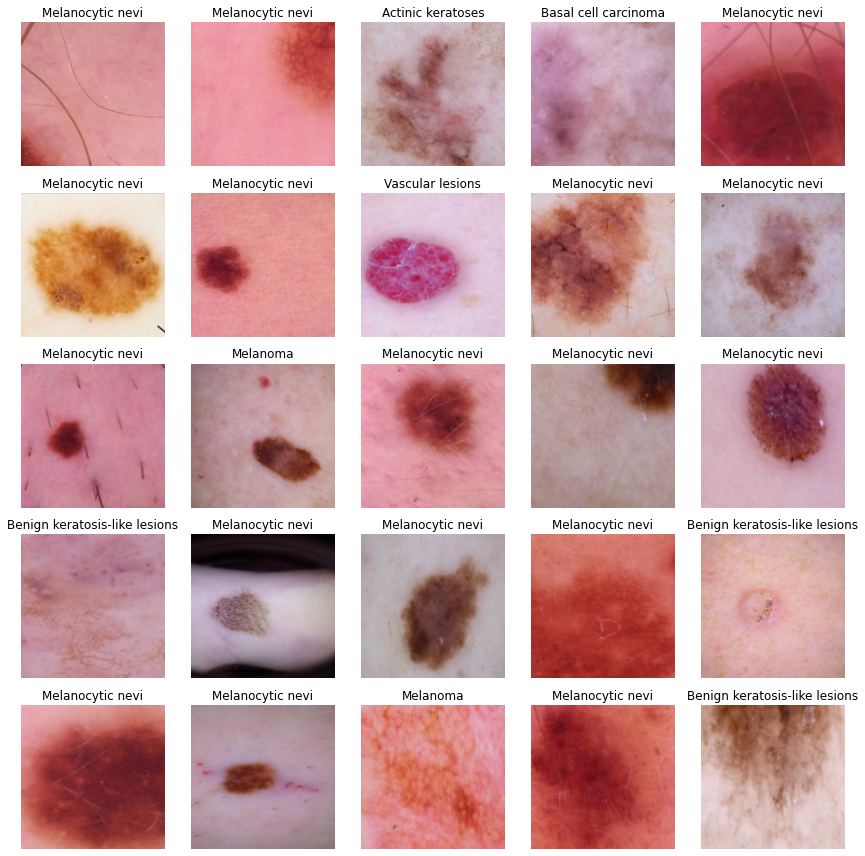

In [ ]:
dm.train_ds.show_grid()

In [ ]:
from nbdev.export import *
notebook2script('dataset_dict.ipynb')

Converted dataset_dict.ipynb.
